In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import pickle
from skimage import io, transform
import cv2
from tqdm.notebook import tqdm
%matplotlib inline

In [151]:
DATASET_PATH = '/home/ilambda/DeepFashion/Category_and_Attribute_prediction_benchmark'
YOLO_DATASET_PATH = '/home/ilambda/DeepFashion/yolo'

In [5]:
bbox_img = pd.read_csv('image_boundingbox.csv', index_col='index')
bbox_img.head()

,image_name,x_1,y_1,x_2,y_2
index,,,,,
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262


In [6]:
def convert_labels(path, x1, y1, x2, y2):
    """
    Definition: Parses label files to extract label and bounding box
        coordinates.  Converts (x1, y1, x1, y2) KITTI format to
        (x, y, width, height) normalized YOLO format.
    """
    def sorting(l1, l2):
        if l1 > l2:
            lmax, lmin = l1, l2
            return lmax, lmin
        else:
            lmax, lmin = l2, l1
            return lmax, lmin
    size = get_img_shape(path)
    xmax, xmin = sorting(x1, x2)
    ymax, ymin = sorting(y1, y2)
    dw = 1./size[1]
    dh = 1./size[0]
    x = (xmin + xmax)/2.0
    y = (ymin + ymax)/2.0
    w = xmax - xmin
    h = ymax - ymin
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def get_img_shape(p):
    path = os.path.join(DATASET_PATH,p)
    img = cv2.imread(path)
    try:
        return img.shape
    except AttributeError:
        print('error! ', path)
        return (None, None, None, None)


In [ ]:
bbox_img[['x','y','width','height']] = bbox_img.apply(lambda row: 
                                                          convert_labels(row['image_name'], row['x_1'], 
                                                                         row['y_1'], row['x_2'],
                                                                         row['y_2']),axis=1, result_type='expand')

In [134]:
def from_yolo_to_cor(box, shape):
    img_h, img_w, _ = shape
    # x1, y1 = ((x + witdth)/2)*img_width, ((y + height)/2)*img_height
    # x2, y2 = ((x - witdth)/2)*img_width, ((y - height)/2)*img_height
    x1, y1 = int((box[0] + box[2]/2)*img_w), int((box[1] + box[3]/2)*img_h)
    x2, y2 = int((box[0] - box[2]/2)*img_w), int((box[1] - box[3]/2)*img_h)
    return x1, y1, x2, y2
    
def draw_boxes(img, boxes):
    for box in boxes:
        x1, y1, x2, y2 = from_yolo_to_cor(box, img.shape)
        im1 = cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 3)
    plt.imshow(im1)
    print(im1.shape)
    
def resize_bbox(img, box, target_size=(300,448)):
    # img.shape returns (H,W,D)
    orig_size = img.shape
    # CV2 target size is opposite of numpy
    im2 = cv2.resize(img, (target_size[1], target_size[0]))
    x_scale = target_size[1]/orig_size[1]
    y_scale = target_size[0]/orig_size[0]
    x_1 = int(box[0] * x_scale)
    y_1 = int(box[1] * y_scale)
    x_2 = int(box[2] * x_scale)
    y_2 = int(box[3] * y_scale)
    
    im2 = cv2.rectangle(im2, (x_1, y_1), (x_2, y_2), (0, 0, 255), 2)
    plt.imshow(im2)
    print(im2.shape)

### Add the category_label and evaluation_status
- creates a new dataframe (df_yolo)
- merge with cat_img_df to add the category_label, category_id, category_type columns
- merge with train_split_df to add the evaluation_status column

In [138]:
cat_img_df  = pd.read_csv('image_category_mapping.csv', index_col='index')

In [140]:
df_yolo = pd.merge(bbox_img, cat_img_df, on='image_name')

In [142]:
train_split_df = pd.read_csv('train_test_split.csv', index_col='index')

,image_name,evaluation_status
index,,
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test


In [143]:
df_yolo = pd.merge(df_yolo, train_split_df, on='image_name')

In [147]:
df_yolo.head()

,image_name,x_1,y_1,x_2,y_2,x,y,width,height,category_label,category_name,category_type,evaluation_status,name
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273,0.506667,0.586667,0.533333,0.646667,3,Blouse,1,train,img_00000001.jpg
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161,0.541463,0.366667,0.429268,0.340000,3,Blouse,1,train,img_00000002.jpg
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200,0.533816,0.441667,0.439614,0.450000,3,Blouse,1,val,img_00000003.jpg
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182,0.545000,0.488000,0.580000,0.480000,3,Blouse,1,train,img_00000004.jpg
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262,0.530000,0.583333,0.600000,0.580000,3,Blouse,1,test,img_00000005.jpg


### Resize the original image to (448, 448) and save to disk
- location YOLO_DATASET_PATH = "/home/ilambda/DeepFashion/yolo"
- update the df "df_yolo" to add a new column "new_name" that stores the name of the resized image

In [146]:
df_yolo['name'] = df_yolo['image_name'].apply(lambda x: x.split("/")[-1])

In [192]:
df_yolo.to_csv('bbox_yolo.csv', index_label='index')

In [152]:
def resize_save_image(idx, df=df_yolo, sourcerootdir=DATASET_PATH, targetrootdir=YOLO_DATASET_PATH, target_size=(448, 448)):
    source_path = os.path.join(sourcerootdir, df.iloc[idx]['image_name'])
    target_name = f"{idx}_{df.iloc[idx]['category_name']}.jpg"
    target_path = os.path.join(targetrootdir, target_name)
    img = cv2.imread(source_path)
    img2 = cv2.resize(img, target_size)
    cv2.imwrite(target_path, img2)
    
    return target_name

In [155]:

idx_to_name = {}
for idx in tqdm(df_yolo.index):
    img_name = resize_save_image(idx)
    idx_to_name[idx] = img_name

In [163]:
df_yolo['new_name'] = df_yolo.apply(lambda x: idx_to_name[x.name], axis=1)

### Add the resized coordinates to the dataframe for image_size = (448,448)

In [237]:
def resize_bbox_coordinates(row, sourcerootdir=DATASET_PATH, targetrootdir=YOLO_DATASET_PATH, target_size=(448,448)):
    """
    lambda function to be used with df.apply()
    Resizes the bounding boxes according to the newly resized image (448, 448)
    """
    target_path = os.path.join(targetrootdir, row['new_name'])
    source_path = os.path.join(sourcerootdir, row['image_name'])
    img = cv2.imread(source_path)
    orig_size = img.shape
    # CV2 target size is opposite of numpy
    im2 = cv2.resize(img, (target_size[1], target_size[0]))
    x_scale = target_size[1]/orig_size[1]
    y_scale = target_size[0]/orig_size[0]
    new_x_1 = int(row['x_1'] * x_scale)
    new_y_1 = int(row['y_1'] * y_scale)
    new_x_2 = int(row['x_2'] * x_scale)
    new_y_2 = int(row['y_2'] * y_scale)

    return new_x_1, new_y_1, new_x_2, new_y_2

In [173]:
df_yolo[['new_x_1','new_y_1','new_x_2','new_y_2']] = df_yolo.apply(lambda x: resize_bbox_coordinates(x), axis=1, result_type='expand')

In [174]:
df_yolo.head()

,image_name,x_1,y_1,x_2,y_2,x,y,width,height,category_label,category_name,category_type,evaluation_status,name,new_name,new_x_1,new_y_1,new_x_2,new_y_2
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273,0.506667,0.586667,0.533333,0.646667,3,Blouse,1,train,img_00000001.jpg,0_Blouse.jpg,107,117,346,407
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161,0.541463,0.366667,0.429268,0.340000,3,Blouse,1,train,img_00000002.jpg,1_Blouse.jpg,146,88,338,240
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200,0.533816,0.441667,0.439614,0.450000,3,Blouse,1,val,img_00000003.jpg,2_Blouse.jpg,140,97,337,298
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182,0.545000,0.488000,0.580000,0.480000,3,Blouse,1,train,img_00000004.jpg,3_Blouse.jpg,114,111,374,326
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262,0.530000,0.583333,0.600000,0.580000,3,Blouse,1,test,img_00000005.jpg,4_Blouse.jpg,103,131,371,391


### Functions to display the image with bounding box

In [236]:
def draw_bb(idx, df=df_yolo, targetrootdir=YOLO_DATASET_PATH):
    """
    Displays the resized image and its bounding box from the dataframe
    :param: idx: index of the df
    :param: df: dataframe containing the image and bb details (default= df_yolo)
    :param: targetrootdir: dir where images are saved on disk (default: YOLO_DATASET_PATH)
    """
    img = cv2.imread(os.path.join(targetrootdir, df.iloc[idx]['new_name']))
    img = cv2.rectangle(img, (df.iloc[idx]['new_x_1'], df.iloc[idx]['new_y_1']), (df.iloc[idx]['new_x_2'], df.iloc[idx]['new_y_2']), (0, 0, 255), 2)
    plt.imshow(img)
    plt.title(df.iloc[idx]['new_name'])
    plt.show()
    
def draw_original_bb(idx, df=df_yolo, targetrootdir=DATASET_PATH):
    """
    Displays the original image and its bounding box from the dataframe
    :param: idx: index of the df
    :param: df: dataframe containing the image and bb details (default= df_yolo)
    :param: targetrootdir: dir where original images are saved on disk (default: DATASET_PATH)
    """
    img = cv2.imread(os.path.join(targetrootdir, df.iloc[idx]['image_name']))
    img = cv2.rectangle(img, (df.iloc[idx]['x_1'], df.iloc[idx]['y_1']), (df.iloc[idx]['x_2'], df.iloc[idx]['y_2']), (0, 0, 255), 2)
    plt.imshow(img)
    plt.title(df.iloc[idx]['image_name'])
    plt.show()

### Verify the original image bb and the resized image bb

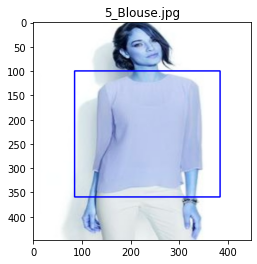

In [190]:
draw_bb(5)

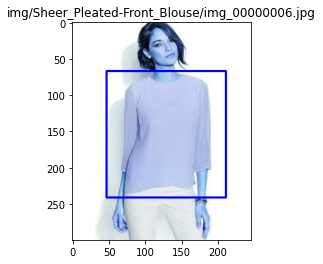

In [191]:
draw_original_bb(5)

In [219]:
def from_coords_to_yolo(row, target_size=(448,448)):
    """
    Definition: Parses label files to extract label and bounding box
        coordinates.  Converts (x1, y1, x1, y2) KITTI format to
        (x, y, width, height) normalized YOLO format.
    """
    
    x1, y1, x2, y2 = row['new_x_1'], row['new_y_1'], row['new_x_2'], row['new_y_2']
    #size = get_img_shape(path)
    #xmax, xmin = sorting(x1, x2)
    #ymax, ymin = sorting(y1, y2)
    dw = 1./target_size[1]
    dh = 1./target_size[0]
    x = (x1 + x2)/2.0
    y = (y1 + y2)/2.0
    w = abs(x2 - x1)
    h = abs(y2 - y1)
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return x,y,w,h

def from_yolo_to_coords(box, target_size=(448,448)):
    """
    Converts the yolo formatted (center coords and width, height) to coords of corners (top-left and bottom-right)
    :param: box: [x, y, w, h]
    """
    img_h, img_w = target_size
    x1, y1 = int((box[0] + box[2]/2)*img_w), int((box[1] + box[3]/2)*img_h)
    x2, y2 = int((box[0] - box[2]/2)*img_w), int((box[1] - box[3]/2)*img_h)
    return x1, y1, x2, y2

def draw_bb_from_coords(img, bbox):
    img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (225,0,0), 2)
    plt.imshow(img)
    plt.title(bbox)
    plt.show()

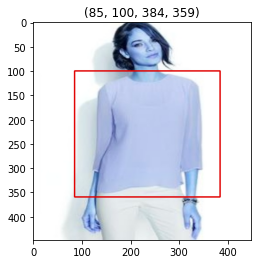

In [229]:
row = df_yolo.iloc[5]
orig_bbox = (row['new_x_1'], row['new_y_1'], row['new_x_2'], row['new_y_2'])
img = cv2.imread(os.path.join(YOLO_DATASET_PATH, row['new_name']))
draw_bb_from_coords(img, orig_bbox)

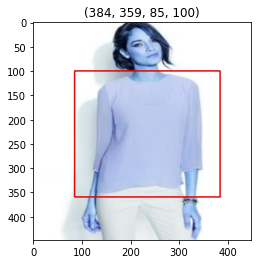

In [230]:
y = from_coords_to_yolo(row)
c = from_yolo_to_coords(y)
draw_bb_from_coords(img, c)

In [222]:
df_yolo[['new_x','new_y','new_width','new_height']] = df_yolo.apply(lambda x: from_coords_to_yolo(x), axis=1, result_type='expand')

### Save the datafarme to disk

In [239]:
df_yolo.to_csv('deepfashion_yolo.csv', index_label='index')

### Display the resized image with bb

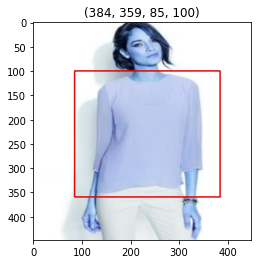

In [228]:
idx = 5
row = df_yolo.iloc[idx]
img = cv2.imread(os.path.join(YOLO_DATASET_PATH, row['new_name']))
y = (row['new_x'], row['new_y'], row['new_width'], row['new_height'])
c = from_yolo_to_coords(y)
draw_bb_from_coords(img, c)

### yolo_df details
Saved on disk at /home/ilambda/goods_viewer/Debasish/torch/deepfashion_yolo.csv
- new_name: stores the name of the resized image. Path on disk is YOLO_DATASET_PATH = "/home/ilambda/DeepFashion/yolo"
- (new_x_1,	new_y_1,	new_x_2,	new_y_2) are the bb coords for resized image (448, 448)
- (new_x,	new_y,	new_width,	new_height) are yolo format bb details for resized image (center coords (x,y), width, height)
- category_label: stores the label id 
- cateogry_name: stores the category name corresponding to the category_id
- category_type: stores the higher label category types 
- evaluation_status: stores flags (train, val, test) to distinguish images between train, val and test sets
- image_name: Name of the original image. Path on disk is DATASET_PATH = '/home/ilambda/DeepFashion/Category_and_Attribute_prediction_benchmark'
- (x_1,y_1,x_2,y_2) are the bb coords for original image
- (x,y,width,height) are yolo format bb details for original image (center coords (x,y), width, height)

In [232]:
df_yolo.head()

,image_name,x_1,y_1,x_2,y_2,x,y,width,height,category_label,...,name,new_name,new_x_1,new_y_1,new_x_2,new_y_2,new_x,new_y,new_width,new_height
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,72,79,232,273,0.506667,0.586667,0.533333,0.646667,3,...,img_00000001.jpg,0_Blouse.jpg,107,117,346,407,0.505580,0.584821,0.533482,0.647321
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161,0.541463,0.366667,0.429268,0.340000,3,...,img_00000002.jpg,1_Blouse.jpg,146,88,338,240,0.540179,0.366071,0.428571,0.339286
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200,0.533816,0.441667,0.439614,0.450000,3,...,img_00000003.jpg,2_Blouse.jpg,140,97,337,298,0.532366,0.440848,0.439732,0.448661
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182,0.545000,0.488000,0.580000,0.480000,3,...,img_00000004.jpg,3_Blouse.jpg,114,111,374,326,0.544643,0.487723,0.580357,0.479911
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262,0.530000,0.583333,0.600000,0.580000,3,...,img_00000005.jpg,4_Blouse.jpg,103,131,371,391,0.529018,0.582589,0.598214,0.580357


In [233]:
df_yolo.columns

Index(['image_name', 'x_1', 'y_1', 'x_2', 'y_2', 'x', 'y', 'width', 'height',
       'category_label', 'category_name', 'category_type', 'evaluation_status',
       'name', 'new_name', 'new_x_1', 'new_y_1', 'new_x_2', 'new_y_2', 'new_x',
       'new_y', 'new_width', 'new_height'],
      dtype='object')